In [4]:
!pip install transformers
!pip install torch
!pip install pandas
!pip install pandas matplotlib seaborn pyvi

In [5]:
import pandas as pd
import torch
from transformers import AutoTokenizer, AutoModelForSequenceClassification
from torch.utils.data import Dataset, DataLoader
import numpy as np
from datasets import Dataset
import torch
from torch.nn import CrossEntropyLoss
from torch.optim import AdamW
from transformers import get_scheduler, AutoTokenizer, AutoModelForSequenceClassification
from tqdm import tqdm
import os
import glob
from sklearn.metrics import confusion_matrix, classification_report
import matplotlib.pyplot as plt
import seaborn as sns
import re
from pyvi.ViTokenizer import ViTokenizer

# Load & Clean Data

In [6]:
df_train = pd.read_csv('/kaggle/input/vietnamese-food-review-dataset/train.csv', encoding='utf-8')
df_valid = pd.read_csv('/kaggle/input/vietnamese-food-review-dataset/valid.csv', encoding='utf-8')
df_test = pd.read_csv('/kaggle/input/vietnamese-food-review-dataset/test.csv', encoding='utf-8')

In [7]:
label_mapping = {
    0: "Tiêu cực",
    1: "Tích cực"
}
unique_labels = sorted(label_mapping.keys())  # Lấy các khóa (0 và 1)

# Tạo label2id và id2label dựa trên ánh xạ
label2id = {label_mapping[label]: label for label in unique_labels}
id2label = {label: label_mapping[label] for label in unique_labels}

print(id2label[0],"|",id2label[1])
print(label2id["Tích cực"])

Tiêu cực | Tích cực
1


In [8]:
df_train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 30000 entries, 0 to 29999
Data columns (total 2 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   sentence  30000 non-null  object
 1   label     30000 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 468.9+ KB


In [9]:
df_train.head()

,sentence,label
0,ăn thử thấy tàu hủ dở mà nhạt quá đá thì ko là...,0
1,quán đông kem xôi dừa khá ngon còn lại rất bìn...,0
2,ăn ở đây lần và mãi mãi k quay lại khách mới n...,0
3,quán nhỏ decor xinh xắn vị trí khá thuận lợi v...,0
4,ưu điểm nhân viên nhiệt tình khuyết điểm lên m...,0


In [10]:
df_train['sentence'].nunique()

29981

In [11]:
df_train['label'].nunique()

2

In [12]:
df_train["label"].value_counts()

label
0    15000
1    15000
Name: count, dtype: int64

# Preprocess

In [13]:
def preprocess_text(text):
    # Chuyển đổi thành chữ thường
    text = text.lower().strip()

    # Loại bỏ URL
    text = re.sub(r'http\S+|www\S+|https\S+', '', text, flags=re.MULTILINE)

    # Loại bỏ các ký tự không phải chữ cái hoặc số
    text = re.sub(r'[^a-zA-Z0-9\s\u00C0-\u1EF9]', '', text)  # Bao gồm cả ký tự tiếng Việt

    # Loại bỏ khoảng trắng thừa
    text = re.sub(r'\s+', ' ', text).strip()


    return text

In [14]:
# Tải stopwords một lần
with open('/kaggle/input/vietnamese-food-review-dataset/vietnamese-stopwords.txt', 'r', encoding='utf-8') as f:
    vietnamese_stopwords = set(line.strip() for line in f)

def remove_stopwords(text):
    return ' '.join([word for word in text.split() if word not in vietnamese_stopwords])

In [15]:
def tokenizer_text(text, tokenized=True, lowercased=True):

    # Bước 1: Làm sạch văn bản
    text = preprocess_text(text)

    # Bước 2: Tách từ tiếng Việt (nếu cần)
    text = ViTokenizer.tokenize(text) if tokenized else text

    # Bước 3: Loại bỏ sstopwords
    text = remove_stopwords(text)


    return text

In [16]:
# Ví dụ sử dụng
comment = "Đây là một bình luận tuyệt vời! a999z ... =))))  Hãy xem tại https://example.com"
processed_comment = tokenizer_text(comment)
print(processed_comment)

bình_luận tuyệt_vời a999z


In [17]:
# Áp dụng hàm tokenizer_text lên cột sentence
df_train['sentence']  = df_train['sentence'].apply(tokenizer_text)
df_valid['sentence']  = df_valid['sentence'].apply(tokenizer_text)
df_test['sentence']  = df_test['sentence'].apply(tokenizer_text)

In [18]:
df_train.head(10)

,sentence,label
0,thử tàu hủ dở nhạt quá đá ko đá xay đá bi thạc...,0
1,quán đông kem xôi dừa ngon rất bình_thường giá...,0
2,ăn_ở mãi_mãi k menu gọi món nhân_viên trả_lời ...,0
3,quán decor xinh_xắn vị_trí thuận_lợi nằm khu c...,0
4,ưu_điểm nhân_viên nhiệt_tình khuyết_điểm món l...,0
5,quán rất xinh_xắn uống trà sữa ok ko thơm trà ...,0
6,thất_vọng món bánh_canh bò chẳng chút hương_vị...,0
7,chẳng hôm nv phục_vụ ko đợi tiếng đồng_hồ đồ đ...,0
8,quán nhiều món mì gọi món mì thịt bằm mì hải_s...,0
9,đi gọi bò lẩu bò mặn thịt lẩu đốm thâm đen nhâ...,0


In [19]:
df_train.tail(10)

,sentence,label
29990,bánh rẻ ngon thân_thiện vô_cùng,1
29991,gà viên mật_ong miến trộn gà viên mật_ong ngon...,1
29992,quán lầu cảm_giác ồn_ào hẳn dứoi quá đông đa_s...,1
29993,quán đẹp siêu thích không_gian bố_trí gọn_gàng...,1
29994,ghé quán quán mì rất ngon sốt đậm_đà chỗ nhiều...,1
29995,đi bắt_gặp đc bánh trứng thần_thánh bánh ra_lò...,1
29996,brilliant hotel khách_sạn lý_tưởng đôi đi du_l...,1
29997,giá_cả phải_chăng phù_hợp_chất_lượng phục_vụ d...,1
29998,ghé quán đẹp không_gian sang_trọng vừa_mới tha...,1
29999,minh đi ăn_ở đầu chưa cơm mì ramen toàn udon k...,1


In [20]:
# Load tokenizer và model
tokenizer = AutoTokenizer.from_pretrained("vinai/phobert-base")
model = AutoModelForSequenceClassification.from_pretrained("vinai/phobert-base",num_labels=len(df_train['label'].unique()))

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

config.json:   0%|          | 0.00/557 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

bpe.codes: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

2025-06-28 06:51:42.437066: E external/local_xla/xla/stream_executor/cuda/cuda_fft.cc:477] Unable to register cuFFT factory: Attempting to register factory for plugin cuFFT when one has already been registered
E0000 00:00:1751093502.635592      35 cuda_dnn.cc:8310] Unable to register cuDNN factory: Attempting to register factory for plugin cuDNN when one has already been registered
E0000 00:00:1751093502.694066      35 cuda_blas.cc:1418] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered


pytorch_model.bin:   0%|          | 0.00/543M [00:00<?, ?B/s]

Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at vinai/phobert-base and are newly initialized: ['classifier.dense.bias', 'classifier.dense.weight', 'classifier.out_proj.bias', 'classifier.out_proj.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


model.safetensors:   0%|          | 0.00/543M [00:00<?, ?B/s]

RobertaForSequenceClassification(
  (roberta): RobertaModel(
    (embeddings): RobertaEmbeddings(
      (word_embeddings): Embedding(64001, 768, padding_idx=1)
      (position_embeddings): Embedding(258, 768, padding_idx=1)
      (token_type_embeddings): Embedding(1, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-05, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (encoder): RobertaEncoder(
      (layer): ModuleList(
        (0-11): 12 x RobertaLayer(
          (attention): RobertaAttention(
            (self): RobertaSdpaSelfAttention(
              (query): Linear(in_features=768, out_features=768, bias=True)
              (key): Linear(in_features=768, out_features=768, bias=True)
              (value): Linear(in_features=768, out_features=768, bias=True)
              (dropout): Dropout(p=0.1, inplace=False)
            )
            (output): RobertaSelfOutput(
              (dense): Linear(in_features=768, out_features=768, bias=True)
         

In [21]:
def tokenize_function(examples):
    return tokenizer(
        examples['sentence'],
        padding='max_length',
        truncation=True,
        max_length=256
    )

In [51]:
# Chuyển dataframe thành datasets của Hugging Face
train_dataset = Dataset.from_pandas(df_train)
val_dataset = Dataset.from_pandas(df_valid)
test_dataset = Dataset.from_pandas(df_test)
print("Datasets đã được tạo:")
print(train_dataset)
print(len(val_dataset))
print(len(test_dataset))

Datasets đã được tạo:
Dataset({
    features: ['sentence', 'label'],
    num_rows: 30000
})
10000
10000


In [23]:
# Áp dụng tokenize
train_dataset = train_dataset.map(tokenize_function, batched=True)
val_dataset = val_dataset.map(tokenize_function, batched=True)
test_dataset = test_dataset.map(tokenize_function, batched=True)

Map:   0%|          | 0/30000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

Map:   0%|          | 0/10000 [00:00<?, ? examples/s]

In [24]:
# Định dạng dữ liệu cho PyTorch
train_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
val_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])
test_dataset.set_format(type='torch', columns=['input_ids', 'attention_mask', 'label'])

In [25]:
# Tạo DataLoader
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=32)
test_loader = DataLoader(test_dataset, batch_size=32)

In [26]:
print(train_dataset[666])

{'label': tensor(0), 'input_ids': tensor([    0,  1152,   720,   549,    57,  1093,  9756,  2908,   653,   133,
         1340,  1118,  1302,  3482,   533,    17,  1564,   957,  2710,  7589,
         1529, 30478,   946,   441,  7589,  1529, 30478,   710,  7589,  1529,
        30478,  2710,  2150,  2023,  2150,  5551,   653, 36066,  2025,  2272,
        26256,  2025,  2272,  4451,  9291,  1032,   204,  2169,   533, 49833,
         1329,  9354,     2,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,     1,     1,     1,     1,     1,     1,     1,
            1,     1,     1,  

In [27]:
# stop ở epoch 7 nhưng chỉ save model epoch 6
class EarlyStopping:
    def __init__(self, patience=5, verbose=False, delta=0):
        """
        patience: Số lượng epoch chờ trước khi dừng.
        verbose: Hiển thị thông tin khi dừng.
        delta: Ngưỡng cải thiện nhỏ nhất để không dừng.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.delta = delta

    def __call__(self, val_loss, model):
        score = -val_loss
        if self.best_score is None:
            self.best_score = score
            self.save_best_model(val_loss, model)
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f"EarlyStopping counter: {self.counter} out of {self.patience}")
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_best_model(val_loss, model)
            self.counter = 0

    def save_best_model(self, val_loss, model):
        """Lưu trạng thái mô hình tốt nhất."""
        if self.verbose:
            print("Saving model... ")
        torch.save(model.state_dict(), os.path.join(checkpoint_dir, "best_model_state.bin"))

In [28]:
def save_checkpoint(epoch, model, optimizer, scheduler, val_loss, checkpoint_dir, max_checkpoints=3):
    """Lưu trạng thái mô hình, optimizer và scheduler sau mỗi epoch."""
    checkpoint = {
             'epoch': epoch,
             'model_state_dict': model.state_dict(),
             'optimizer_state_dict': optimizer.state_dict(),
             'scheduler_state_dict': scheduler.state_dict(),
             'val_loss': val_loss
         }
    checkpoint_path = os.path.join(checkpoint_dir, f"checkpoint_epoch_{epoch}.pt")
    torch.save(checkpoint, checkpoint_path)
    print(f"Saved checkpoint at epoch {epoch} to {checkpoint_path}")

    # Xóa checkpoint cũ nếu vượt quá max_checkpoints
    checkpoint_files = sorted(glob.glob(os.path.join(checkpoint_dir, "checkpoint_epoch_*.pt")),
                              key=lambda x: int(x.split('_')[-1].split('.pt')[0]))
    if len(checkpoint_files) > max_checkpoints:
        for old_checkpoint in checkpoint_files[:-max_checkpoints]:
            os.remove(old_checkpoint)
            print(f"Deleted old checkpoint: {old_checkpoint}")

def load_checkpoint(checkpoint_path, model, optimizer, scheduler, device):
    """Tải trạng thái từ checkpoint."""
    checkpoint = torch.load(checkpoint_path, map_location=device)
    model.load_state_dict(checkpoint['model_state_dict'])
    optimizer.load_state_dict(checkpoint['optimizer_state_dict'])
    scheduler.load_state_dict(checkpoint['scheduler_state_dict'])
    start_epoch = checkpoint['epoch'] + 1
    val_loss = checkpoint.get('val_loss', float('inf'))
    print(f"Loaded checkpoint from {checkpoint_path}, resuming at epoch {start_epoch}")
    return start_epoch, val_loss

In [33]:
# Thiết lập Optimizer
optimizer = AdamW(model.parameters(), lr=2e-5)

# Thiết lập Scheduler
n_epochs = 10
num_training_steps = len(train_loader) * n_epochs
scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps
)

checkpoint_dir = "./checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [30]:
# Định nghĩa hàm tính accuracy và hàm train/validation
loss_fn = CrossEntropyLoss()

def calculate_accuracy(preds, labels):
    preds = torch.argmax(preds, dim=1)
    correct = (preds == labels).sum().item()
    return correct / len(labels)

def train_epoch(model, data_loader, loss_fn, optimizer, device, scheduler):
    model.train()
    total_loss = 0
    correct_predictions = 0
    for batch in tqdm(data_loader, desc="Training"):
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['label'].to(device)
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        logits = outputs.logits
        loss = loss_fn(logits, labels)
        correct_predictions += calculate_accuracy(logits, labels) * len(labels)
        total_loss += loss.item()
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        scheduler.step()
    return total_loss / len(data_loader), correct_predictions / len(data_loader.dataset)

def eval_model(model, data_loader, loss_fn, device):
    model.eval()
    total_loss = 0
    correct_predictions = 0
    with torch.no_grad():
        for batch in tqdm(data_loader, desc="Evaluating"):
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            loss = loss_fn(logits, labels)
            correct_predictions += calculate_accuracy(logits, labels) * len(labels)
            total_loss += loss.item()
    return total_loss / len(data_loader), correct_predictions / len(data_loader.dataset)

In [34]:
# Wandb tracking
from kaggle_secrets import UserSecretsClient
user_secrets = UserSecretsClient()
secret_value_1 = user_secrets.get_secret("wandb.login")
import os
import wandb

wandb.login(key=secret_value_1)
wandb.init(
    project="PhoBERT-Sentiment-Analysis", 
    name="phobert-v1",                
    config={
        "model": "vinai/phobert-base",
        "tokenizer": "vinai/phobert-base",
        "batch_size": 32,
        "learning_rate": 2e-5,
        "epochs": 2,
        "max_length": 256
    }  
)

# Kiểm tra và tải checkpoint mới nhất
start_epoch = 0
best_val_loss = float('inf')
checkpoint_dir = "./checkpoints"
checkpoint_files = [f for f in os.listdir(checkpoint_dir) if f.startswith("checkpoint_epoch_")]
if checkpoint_files:
    latest_checkpoint = max(checkpoint_files, key=lambda x: int(x.split('_')[-1].split('.pt')[0]))
    checkpoint_path = os.path.join(checkpoint_dir, latest_checkpoint)
    start_epoch, best_val_loss = load_checkpoint(checkpoint_path, model, optimizer, scheduler, device)

# Khởi tạo Early Stopping
early_stopping = EarlyStopping(patience=5, verbose=True)

# Vòng lặp huấn luyện
for epoch in range(start_epoch, n_epochs):
    print(f"Epoch {epoch + 1}/{n_epochs}")
    print("-" * 30)
    train_loss, train_acc = train_epoch(
        model, train_loader, loss_fn, optimizer, device, scheduler
    )
    val_loss, val_acc = eval_model(
        model, val_loader, loss_fn, device
    )
    print(f"Train Loss: {train_loss:.4f}, Train Accuracy: {train_acc:.4f}")
    print(f"Val Loss: {val_loss:.4f}, Val Accuracy: {val_acc:.4f}")

    # Ghi lại data lên Wandb
    wandb.log({
        "epoch": epoch + 1,
        "train_loss": train_loss,
        "train_accuracy": train_acc,
        "val_loss": val_loss,
        "val_accuracy": val_acc
    })

    # Lưu checkpoint sau mỗi epoch
    save_checkpoint(epoch, model, optimizer, scheduler, val_loss, checkpoint_dir)

    # Gọi Early Stopping
    early_stopping(val_loss, model)
    if early_stopping.early_stop:
        print("Early stopping triggered. Stopping training.")
        break

wandb.finish()

wandb: WARNING If you're specifying your api key in code, ensure this code is not shared publicly.
wandb: WARNING Consider setting the WANDB_API_KEY environment variable, or running `wandb login` from the command line.
wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Epoch 1/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:36<00:00,  2.00it/s]


Train Loss: 0.3060, Train Accuracy: 0.8737
Val Loss: 0.2690, Val Accuracy: 0.8954
Saved checkpoint at epoch 0 to ./checkpoints/checkpoint_epoch_0.pt
Validation loss decreased (-0.268973). Saving model...
Epoch 2/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


Train Loss: 0.2343, Train Accuracy: 0.9076
Val Loss: 0.2537, Val Accuracy: 0.8994
Saved checkpoint at epoch 1 to ./checkpoints/checkpoint_epoch_1.pt
Validation loss decreased (-0.253682). Saving model...
Epoch 3/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:35<00:00,  2.01it/s]


Train Loss: 0.1996, Train Accuracy: 0.9227
Val Loss: 0.2595, Val Accuracy: 0.8987
Saved checkpoint at epoch 2 to ./checkpoints/checkpoint_epoch_2.pt
EarlyStopping counter: 1 out of 5
Epoch 4/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:35<00:00,  2.02it/s]


Train Loss: 0.1644, Train Accuracy: 0.9402
Val Loss: 0.2613, Val Accuracy: 0.8996
Saved checkpoint at epoch 3 to ./checkpoints/checkpoint_epoch_3.pt
Deleted old checkpoint: ./checkpoints/checkpoint_epoch_0.pt
EarlyStopping counter: 2 out of 5
Epoch 5/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


Train Loss: 0.1409, Train Accuracy: 0.9494
Val Loss: 0.2914, Val Accuracy: 0.8976
Saved checkpoint at epoch 4 to ./checkpoints/checkpoint_epoch_4.pt
Deleted old checkpoint: ./checkpoints/checkpoint_epoch_1.pt
EarlyStopping counter: 3 out of 5
Epoch 6/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:34<00:00,  2.03it/s]


Train Loss: 0.1140, Train Accuracy: 0.9596
Val Loss: 0.3287, Val Accuracy: 0.8975
Saved checkpoint at epoch 5 to ./checkpoints/checkpoint_epoch_5.pt
Deleted old checkpoint: ./checkpoints/checkpoint_epoch_2.pt
EarlyStopping counter: 4 out of 5
Epoch 7/10
------------------------------


Evaluating: 100%|██████████| 313/313 [02:34<00:00,  2.02it/s]


Train Loss: 0.0931, Train Accuracy: 0.9679
Val Loss: 0.3444, Val Accuracy: 0.8941
Saved checkpoint at epoch 6 to ./checkpoints/checkpoint_epoch_6.pt
Deleted old checkpoint: ./checkpoints/checkpoint_epoch_3.pt
EarlyStopping counter: 5 out of 5
Early stopping triggered. Stopping training.


epoch,▁▂▃▅▆▇█
train_accuracy,▁▄▅▆▇▇█
train_loss,█▆▅▃▃▂▁
val_accuracy,▃█▇█▅▅▁
val_loss,▂▁▁▂▄▇█
epoch,7
train_accuracy,0.96793
train_loss,0.09307
val_accuracy,0.8941
val_loss,0.3444


In [54]:
from safetensors.torch import load_file

model_weights = load_file('/kaggle/working/sentiment_model/model.safetensors')
model.load_state_dict(model_weights)

# Đánh giá trên tập kiểm tra
test_loss, test_acc = eval_model(model, test_loader, loss_fn, device)  
print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Evaluating: 100%|██████████| 313/313 [02:35<00:00,  2.01it/s]

Test Loss: 0.3209, Test Accuracy: 0.9017


In [62]:
# thêm xác suất %

def predict_sentiment(text, model, tokenizer):
    model.eval()
    encoding = tokenizer(
        text,
        add_special_tokens=True,
        max_length=256,
        padding='max_length',
        truncation=True,
        return_tensors='pt'
    )
    
    input_ids = encoding['input_ids'].to(device)
    attention_mask = encoding['attention_mask'].to(device)
    
    with torch.no_grad():
        outputs = model(input_ids=input_ids, attention_mask=attention_mask)
        predictions = torch.nn.functional.softmax(outputs.logits, dim=-1)
        predicted_class = torch.argmax(predictions, dim=-1)
    
    return predicted_class.item()
# Ví dụ sử dụng
text = "Tôi vừa đặt 1 xuất cơm vịt mất 70 trên now nhưng cửa hàng lại quên ko cho vịt vào"
sentiment = predict_sentiment(text, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

text2 = """Sooooo good! We’ve tried both the Hanoi location and this one and hands down— taste and quality is amazing.
We actually like it better than a certain Michelin Guide one also in town. The meat is tender and soft here, rice seasoned just right. 
Also their side of soup has minced pork and seaweed. Super tasty!"""
sentiment = predict_sentiment(text2, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

text3 = "Bận đặt về mà 5 phần sống hết 4 phần, mua cho mấy đứa em ăn mà k để ý. Phần ăn giá cao mà chất lượng không đảm bảo"
sentiment = predict_sentiment(text3, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

text4 = "Được miếng sườn để ăn thì còn sống. Này là thịt heo chứ phải thịt bò đâu mà nấu tái vậy. Quảng cáo quá đáng, ăn thì không ra gì, nước mắm thì dở tệ."
sentiment = predict_sentiment(text4, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

text5 = "đồ ăn bình thường, sườn cốt lết bị khô. Được cái không gian thoáng rộng, mát"
sentiment = predict_sentiment(text5, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

text6 = "Cơm tấm ngon, sườn ướp mềm, gia vị nêm nếm ngon. Đặc biệt canh thay đổi mỗi ngày, canh nóng rất ngon"
sentiment = predict_sentiment(text6, model, tokenizer)
print(f"Sentiment: {sentiment}| {id2label[sentiment]}")

Sentiment: 0| Tiêu cực
Sentiment: 1| Tích cực
Sentiment: 0| Tiêu cực
Sentiment: 0| Tiêu cực
Sentiment: 0| Tiêu cực
Sentiment: 1| Tích cực


In [44]:
def get_predictions(model, data_loader, device):
    model.eval()
    predictions = []
    true_labels = []
    
    with torch.no_grad():
        for batch in data_loader:
            input_ids = batch['input_ids'].to(device)
            attention_mask = batch['attention_mask'].to(device)
            labels = batch['label'].to(device)
            
            outputs = model(input_ids=input_ids, attention_mask=attention_mask)
            logits = outputs.logits
            preds = torch.argmax(logits, dim=1)
            
            predictions.extend(preds.cpu().numpy())
            true_labels.extend(labels.cpu().numpy())
    
    return np.array(predictions), np.array(true_labels)

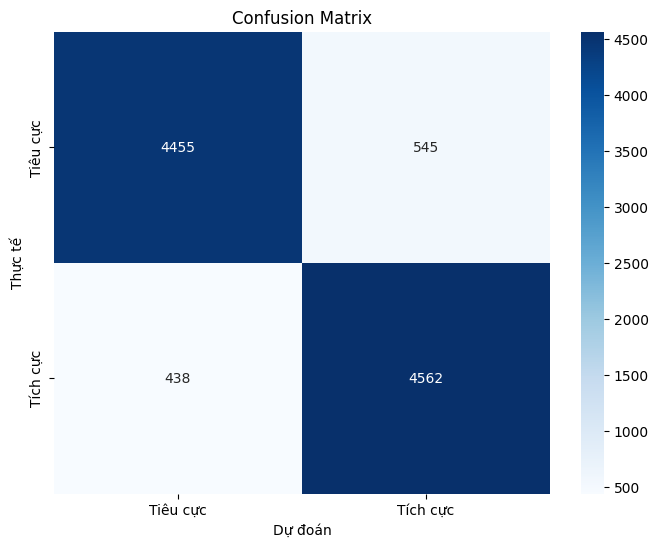

In [45]:
predictions, true_labels = get_predictions(model, test_loader, device)
# Tính confusion matrix
cm = confusion_matrix(true_labels, predictions)

# Vẽ confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', 
            xticklabels=[id2label[i] for i in range(len(id2label))], 
            yticklabels=[id2label[i] for i in range(len(id2label))])
plt.title('Confusion Matrix')
plt.xlabel('Dự đoán')
plt.ylabel('Thực tế')
plt.show()

In [48]:
# Tạo classification report
report = classification_report(true_labels, predictions, 
                              target_names=[id2label[i] for i in range(len(id2label))], 
                              output_dict=False)
print("Classification Report:")
print(report)

Classification Report:
              precision    recall  f1-score   support

    Tiêu cực       0.91      0.89      0.90      5000
    Tích cực       0.89      0.91      0.90      5000

    accuracy                           0.90     10000
   macro avg       0.90      0.90      0.90     10000
weighted avg       0.90      0.90      0.90     10000



In [49]:
# Lưu model
# model.save_pretrained('./sentiment_model')
# tokenizer.save_pretrained('./sentiment_model')

('./sentiment_model/tokenizer_config.json',
 './sentiment_model/special_tokens_map.json',
 './sentiment_model/vocab.txt',
 './sentiment_model/bpe.codes',
 './sentiment_model/added_tokens.json')

In [53]:
# #Zipping and Downloading Output
# !zip -r output.zip /kaggle/working/sentiment_model
# from IPython.display import FileLink
# FileLink('sentiment_model.zip')

updating: kaggle/working/sentiment_model/ (stored 0%)
updating: kaggle/working/sentiment_model/model.safetensors (deflated 14%)
updating: kaggle/working/sentiment_model/added_tokens.json (stored 0%)
updating: kaggle/working/sentiment_model/tokenizer_config.json (deflated 77%)
updating: kaggle/working/sentiment_model/config.json (deflated 50%)
updating: kaggle/working/sentiment_model/bpe.codes (deflated 59%)
updating: kaggle/working/sentiment_model/vocab.txt (deflated 55%)
updating: kaggle/working/sentiment_model/special_tokens_map.json (deflated 57%)


/kaggle/working/sentiment_model.zip